# Installing env


In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pygame
#Make sure to install atari on conda first
#https://anaconda.org/conda-forge/gym-atari
# conda install -c conda-forge gym-atari


In [103]:
#Create 
# What is NO Frame Skip ???
# What's a difference between human and rgb_array mode? 
env = gym.make("BreakoutNoFrameskip-v4", render_mode = 'rgb_array')
print(env.observation_space)
#Documentation
#0: noob, does nothing
#1: fire the ball
#2: right 
#3: left 
print(env.action_space)

Box(0, 255, (210, 160, 3), uint8)
Discrete(4)


A.L.E: Arcade Learning Environment (version 0.8.1+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /Users/jamesnguyen/anaconda3/envs/torch/lib/python3.11/site-packages/AutoROM/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 829582471


In [104]:
# have to call this before render call
env.reset()

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 {'lives': 5, 'episode_frame_number': 0, 'frame_number': 0})

(210, 160, 3)
<class 'numpy.ndarray'>


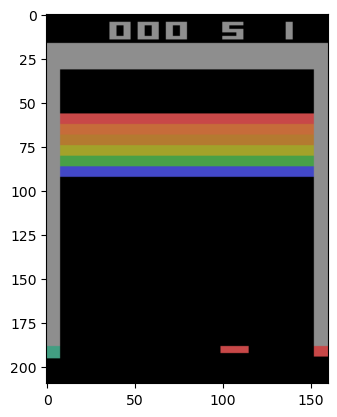

In [105]:
a = env.render()
a = np.array(a)
print(a.shape)
print(type(a))
plt.imshow(a)

In [106]:
# In the Deep Q Learning paper, it resize the original image to 84x84x4, 4 84x84 gray scale images
# 84 is shape
# 4 is 4 consecutive frames that stack together to gives the model context, it's not 4 channesl 

In [98]:
obs, reward, done, terminated, info = env.step(0)
print('state shape = ', obs.shape)
print('reward = ', reward)
print('done = ', done)
print('terminated =', terminated)
print('info =', info)

state shape =  (210, 160, 3)
reward =  0.0
done =  False
terminated = False
info = {'lives': 5, 'episode_frame_number': 6, 'frame_number': 6}


In [92]:
class BreakoutGame:

    def __init__(self, width, height, env):
        print('init game')
        pygame.init()
        self.screen = pygame.display.set_mode((width, height))
        self.clock = pygame.time.Clock()
        self.done = False
        self.env = env
        self.env.reset()
        self.GAME_SPEED = 50

    def render(self):
        while not self.done:
            self.clock.tick(self.GAME_SPEED)
            #get rgb frame ((width, height, channel))
            frame = env.render()
            #transpose to render frame on pygame screen
            frame = np.transpose(frame, (1,0,2))
            img = pygame.surfarray.make_surface(frame)
            self.screen.blit(img, (0,0))
            pygame.display.update()

            # stand still if player does nothing
            self.env.step(0)

            # get key down events
            for event in pygame.event.get():
                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_q:
                        self.done = True
                    if event.key == pygame.K_SPACE:
                        self.env.step(1)
                if event.type == pygame.QUIT:
                    self.done = True
        
            # human only, get keys that are being pressed
            keys = pygame.key.get_pressed()
            if keys[pygame.K_a]:
                    self.env.step(3)
            elif keys[pygame.K_d]:
                    step_info = self.env.step(2)
                
            print(step_info)

        self.env.close()
        pygame.quit()
        print('exit game')
    

In [93]:
observation_space = env.observation_space
action_space = env.action_space
WIDTH = observation_space.shape[1]
HEIGHT = observation_space.shape[0]
print(WIDTH, ' ', HEIGHT)
game = BreakoutGame(WIDTH, HEIGHT, env)
game.render()

160   210
init game


/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


UnboundLocalError: cannot access local variable 'step_info' where it is not associated with a value

# Coding a Deep Q Learning

https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/atari_games.ipynb#scrollTo=t5WNF6G5gWZ1

https://www.youtube.com/watch?v=cNkxCQflixY

https://stable-baselines3.readthedocs.io/en/master/guide/examples.html


https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html

In [47]:
#import stable baselines to quickly run experiments
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
import numpy as np
import matplotlib.pyplot as plt

In [41]:
original_env = make_atari_env("BreakoutNoFrameskip-v4")
print(env.action_space)
env = VecFrameStack(env, n_stack = 4)

Discrete(4)


A.L.E: Arcade Learning Environment (version 0.8.1+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /Users/jamesnguyen/anaconda3/envs/torch/lib/python3.11/site-packages/AutoROM/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -830081800


In [42]:
obs = env.reset()
print(obs.shape)

(1, 84, 84, 4)


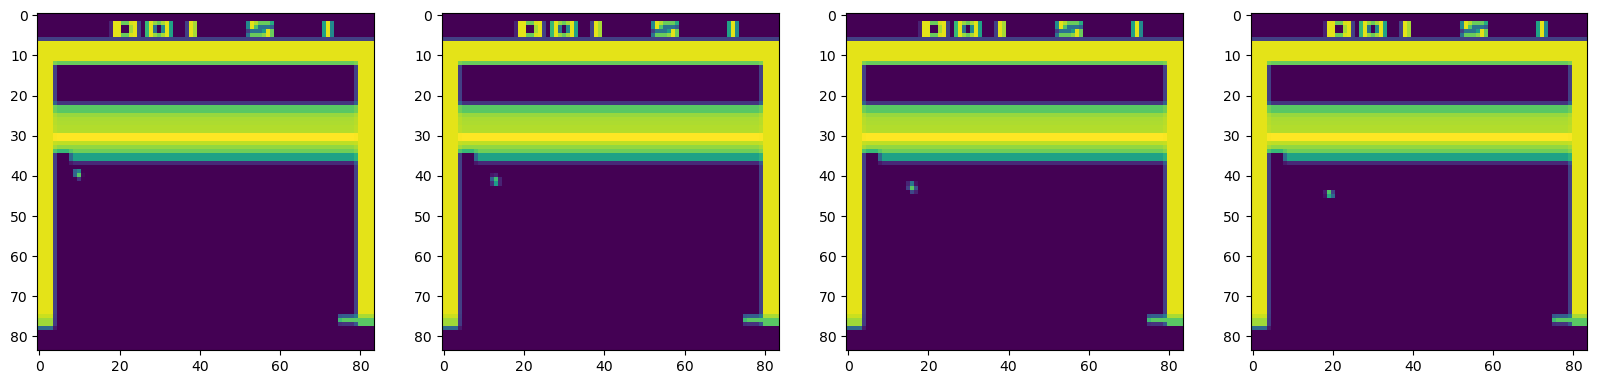

In [73]:
obs, reward, done, info  = env.step(np.array([0]))
obs = np.transpose(obs, (3,0,1,2)).squeeze(1)

fig, axes = plt.subplots(1,obs.shape[0], figsize=(20,30))
#Plot the 4 frames
for i in range(obs.shape[0]):
    axes[i].imshow(obs[i])


#  Building a Deep Q Learning